In [763]:
import torch
import numpy as np
import pandas as pd

import pymysql
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from chinese_calendar import is_workday, is_holiday
from datetime import datetime
from functools import partial
import re
sns.set_style("darkgrid")

In [2]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [3]:
# 从mysql中抽取数据
db = pymysql.connect(host='8.141.169.219',
                     user='root',
                     password='Zrhdb#2019',
                     port=3307,
                     database='WeiCloudAirDB.V4')
cursor = db.cursor()
sql = "SELECT* FROM Tb_HeatMeter_History WHERE parm_002 IN (469951342248480,469951350586400) and parm_003 BETWEEN '2021-01-01' and '2022-08-30'"
cursor.execute(sql)
results = cursor.fetchall()
db.close()

In [4]:
# 根据获取结果生成dataframe
col = [f[0] for f in cursor.description]
y_df = pd.DataFrame(list(results), columns=col)

In [5]:
y_df.columns.values

array(['id', 'parm_001', 'parm_002', 'parm_003', 'Hm_Parm_001',
       'Hm_Parm_002', 'Hm_Parm_003', 'Hm_Parm_004', 'Hm_Parm_005',
       'Hm_Parm_006', 'Hm_Parm_007', 'Hm_Parm_008', 'Hm_Parm_009',
       'Hm_Parm_010', 'Hm_Parm_011', 'Hm_Parm_012', 'Hm_Parm_013',
       'Hm_Parm_014', 'Hm_Parm_015'], dtype=object)

In [6]:
use_y_df = y_df[['parm_002', 'parm_003', 'Hm_Parm_002']]
use_y_df = use_y_df[~pd.isnull(use_y_df['Hm_Parm_002'])]

In [7]:
use_y_df.rename(columns={'parm_002': 'id', 'parm_003': 'date', 'Hm_Parm_002': 'cold_capacity'}, inplace=True)

In [8]:
# 过滤周末和节假日
use_y_df['is_workday'] = use_y_df['date'].apply(lambda x: is_workday(x.to_pydatetime()))
use_y_df = use_y_df.loc[use_y_df['is_workday']]
use_y_df = use_y_df.drop(columns=['is_workday'])
use_y_df.shape

(156190, 3)

In [9]:
# 只考虑制冷时段
use_y_df = use_y_df[use_y_df['date'].dt.month.isin([6, 7, 8])]
use_y_df['date'] = use_y_df['date'].apply(lambda x: x - pd.Timedelta(seconds=x.second))
use_y_df.shape

(56551, 3)

In [10]:
# 两块表加和
id_list = use_y_df['id'].drop_duplicates().values
id_list

array([469951342248480, 469951350586400], dtype=int64)

In [11]:
g = use_y_df.groupby(['id'])
all_df = pd.DataFrame(columns=['date', 'cold_capacity'])
for i, sdf in g:
    sdf = sdf[['date', 'cold_capacity']].sort_values(by=['date'])
    if all_df.empty:
        all_df = sdf.copy()
    else:
        sdf.rename(columns={'cold_capacity': 'temp'}, inplace=True)
        all_df = pd.merge(all_df, sdf, on='date')
        all_df['cold_capacity'] = all_df.apply(lambda s: s['cold_capacity'] + s['temp'], axis=1)
        all_df.drop(columns='temp', inplace=True)

In [12]:
all_df

,date,cold_capacity
0,2021-06-01 14:25:00,6.995000e+05
1,2021-06-01 14:30:00,6.997778e+05
2,2021-06-01 14:35:00,6.997778e+05
3,2021-06-01 14:40:00,6.997778e+05
4,2021-06-01 14:45:00,6.997778e+05
...,...,...
27894,2022-08-12 16:35:00,1.015761e+10
27895,2022-08-12 16:40:00,1.015761e+10
27896,2022-08-12 16:45:00,1.015761e+10
27897,2022-08-12 16:50:00,1.015761e+10


In [13]:
id1_df = all_df.copy()
id1_df.index = np.arange(len(id1_df))

<AxesSubplot:>

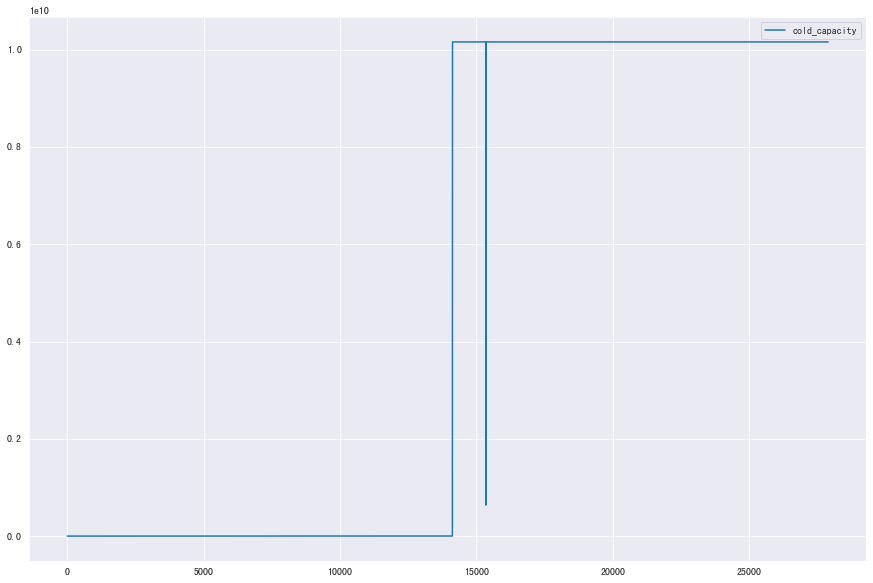

In [14]:
id1_df.plot(y='cold_capacity', figsize=(15, 10))

In [15]:
# iqr
def filter_iqr(arr, k=2):
    temp = arr[(~np.isnan(arr))]
    q1 = np.percentile(temp, 0.25)
    q3 = np.percentile(temp, 0.75)
    iqr = k * (q3 - q1)
    filter_idx = np.argwhere(((arr >= q1 - k * iqr) & (arr <= q3 + k * iqr)) | np.isnan(arr)).flatten()
    return filter_idx

In [16]:
# 3sigma
def sigma3(arr, sig=3):
    temp = arr[(~np.isnan(arr))]
    std = temp.std()
    m = temp.mean()
    use_idx = np.argwhere(((arr >= m - sig * std) & (arr <= m + sig * std)) | np.isnan(arr)).flatten()
    return use_idx

In [17]:
# lof
from sklearn.neighbors import LocalOutlierFactor as LOF
features = id1_df['cold_capacity'].values.reshape(-1, 1)
lm = LOF(n_neighbors=2)
lof_res = lm.fit_predict(features)
print(len(lof_res[lof_res == -1]))
id2_df = id1_df.loc[lof_res == 1]

618


In [18]:
id2_df

,date,cold_capacity
1,2021-06-01 14:30:00,6.997778e+05
2,2021-06-01 14:35:00,6.997778e+05
3,2021-06-01 14:40:00,6.997778e+05
4,2021-06-01 14:45:00,6.997778e+05
5,2021-06-01 14:50:00,7.000556e+05
...,...,...
27894,2022-08-12 16:35:00,1.015761e+10
27895,2022-08-12 16:40:00,1.015761e+10
27896,2022-08-12 16:45:00,1.015761e+10
27897,2022-08-12 16:50:00,1.015761e+10


<AxesSubplot:>

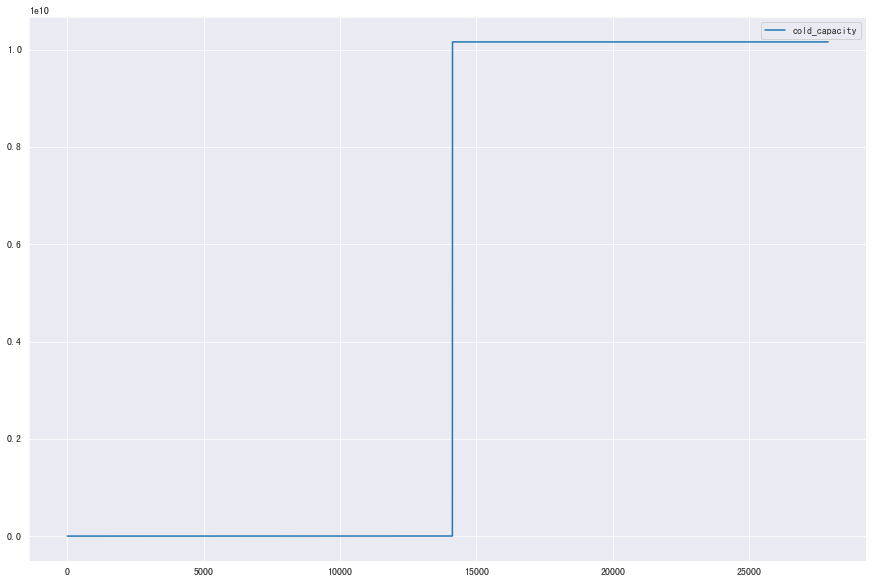

In [19]:
id2_df.plot(y='cold_capacity', figsize=(15, 10))

In [20]:
# 确保时间连续
temp_df = id1_df.copy()
new_df = pd.DataFrame(pd.date_range(start=temp_df['date'].min(), end=temp_df['date'].max(), freq='5min'), columns=['date'])
data_df = pd.merge(new_df, temp_df, on='date', how='left')
data_df = data_df.sort_values(by=['date'])
data_df

,date,cold_capacity
0,2021-06-01 14:25:00,6.995000e+05
1,2021-06-01 14:30:00,6.997778e+05
2,2021-06-01 14:35:00,6.997778e+05
3,2021-06-01 14:40:00,6.997778e+05
4,2021-06-01 14:45:00,6.997778e+05
...,...,...
125886,2022-08-12 16:35:00,1.015761e+10
125887,2022-08-12 16:40:00,1.015761e+10
125888,2022-08-12 16:45:00,1.015761e+10
125889,2022-08-12 16:50:00,1.015761e+10


filter before:  125891
2
21
552
2
0
filter after:  125314


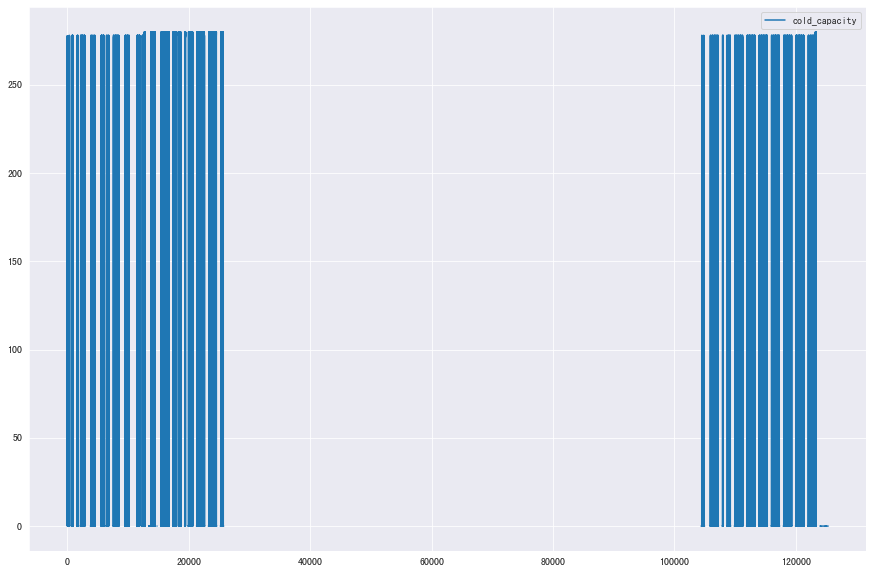

In [21]:
# 差分得到每5min的累积量
diff_cc = data_df['cold_capacity'].diff().values
print('filter before: ', len(diff_cc))
iter_max_counts = 10
for i in range(iter_max_counts):
    bf = len(diff_cc)
    diff_use_idx = sigma3(diff_cc)
    diff_cc = diff_cc[diff_use_idx]
    af = len(diff_cc)
    print(bf - af)
    if np.abs(af - bf) == 0:
        break
print('filter after: ', len(diff_cc))
plt.figure(figsize=(15, 10))
plt.plot(diff_cc, label='cold_capacity')
plt.legend()

In [22]:
# 缩小颗粒度，合并相邻数据点（1h->12个点）
# 先删点后合并
diff_cc_filter = diff_cc[~np.isnan(diff_cc)]

In [23]:
def merge(arr, k=12):
    c = np.cumsum(arr)
    c = np.insert(c, 0, 0)
    return np.diff(c[::k])

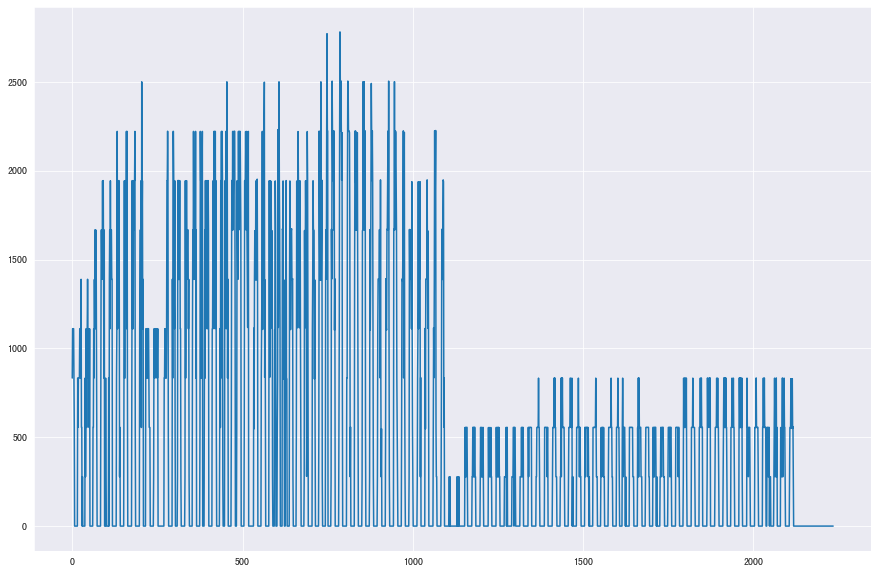

In [24]:
merge_cc = merge(diff_cc_filter, 12)
plt.figure(figsize=(15, 10))
plt.plot(merge_cc)

In [25]:
data_df['cold_capacity_diff'] = data_df['cold_capacity'].diff()

In [26]:
data_df

,date,cold_capacity,cold_capacity_diff
0,2021-06-01 14:25:00,6.995000e+05,NaN
1,2021-06-01 14:30:00,6.997778e+05,277.8
2,2021-06-01 14:35:00,6.997778e+05,0.0
3,2021-06-01 14:40:00,6.997778e+05,0.0
4,2021-06-01 14:45:00,6.997778e+05,0.0
...,...,...,...
125886,2022-08-12 16:35:00,1.015761e+10,0.0
125887,2022-08-12 16:40:00,1.015761e+10,0.0
125888,2022-08-12 16:45:00,1.015761e+10,0.0
125889,2022-08-12 16:50:00,1.015761e+10,0.0


In [27]:
# 删去差分后异常的点
print('filter before: ', data_df.shape[0])
iter_max_counts = 10
bf = data_df.shape[0]
for i in range(iter_max_counts):
    diff_use_idx = sigma3(data_df['cold_capacity_diff'].values)
    filter_idx = np.setdiff1d(np.arange(bf), diff_use_idx)
    data_df.iloc[filter_idx, [1, 2]] = np.nan
    print('filter: ', len(filter_idx))
    if len(filter_idx) == 0:
        break
data_df

filter before:  125891
filter:  2
filter:  21
filter:  552
filter:  2
filter:  0


,date,cold_capacity,cold_capacity_diff
0,2021-06-01 14:25:00,6.995000e+05,NaN
1,2021-06-01 14:30:00,6.997778e+05,277.8
2,2021-06-01 14:35:00,6.997778e+05,0.0
3,2021-06-01 14:40:00,6.997778e+05,0.0
4,2021-06-01 14:45:00,6.997778e+05,0.0
...,...,...,...
125886,2022-08-12 16:35:00,1.015761e+10,0.0
125887,2022-08-12 16:40:00,1.015761e+10,0.0
125888,2022-08-12 16:45:00,1.015761e+10,0.0
125889,2022-08-12 16:50:00,1.015761e+10,0.0


<AxesSubplot:xlabel='date'>

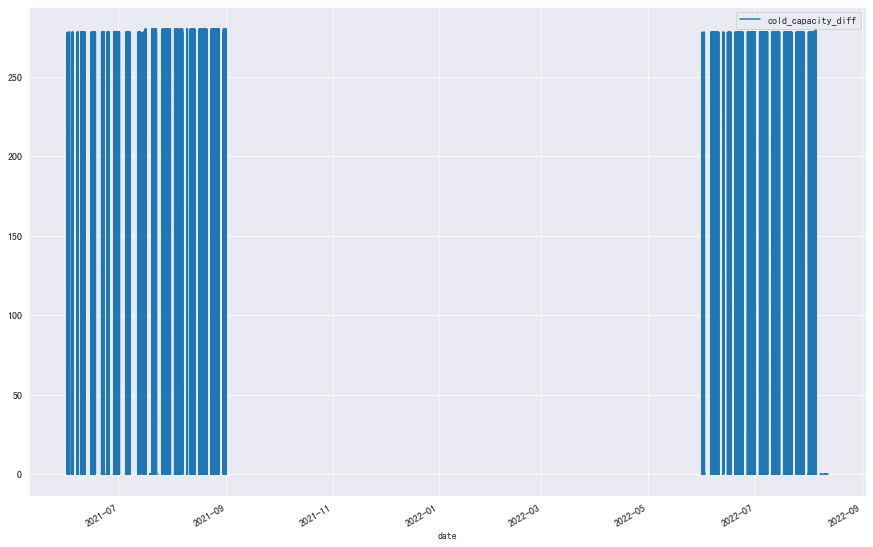

In [28]:
use_df = data_df.copy()
use_df.plot(x='date', y='cold_capacity_diff', figsize=(15, 10))

In [29]:
# 过滤非工作时段
use_df = data_df.copy()
use_df = use_df[use_df['date'].dt.hour.isin(np.arange(7, 19))]
use_df.index = np.arange(len(use_df))
use_df

,date,cold_capacity,cold_capacity_diff
0,2021-06-01 14:25:00,6.995000e+05,NaN
1,2021-06-01 14:30:00,6.997778e+05,277.8
2,2021-06-01 14:35:00,6.997778e+05,0.0
3,2021-06-01 14:40:00,6.997778e+05,0.0
4,2021-06-01 14:45:00,6.997778e+05,0.0
...,...,...,...
62955,2022-08-12 16:35:00,1.015761e+10,0.0
62956,2022-08-12 16:40:00,1.015761e+10,0.0
62957,2022-08-12 16:45:00,1.015761e+10,0.0
62958,2022-08-12 16:50:00,1.015761e+10,0.0


In [183]:
use_df['day'] = use_df['date'].dt.strftime('%Y-%m-%d')
use_df['hour'] = use_df['date'].dt.hour
use_df

,date,cold_capacity,cold_capacity_diff,day,hour
0,2021-06-01 14:25:00,6.995000e+05,NaN,2021-06-01,14
1,2021-06-01 14:30:00,6.997778e+05,277.8,2021-06-01,14
2,2021-06-01 14:35:00,6.997778e+05,0.0,2021-06-01,14
3,2021-06-01 14:40:00,6.997778e+05,0.0,2021-06-01,14
4,2021-06-01 14:45:00,6.997778e+05,0.0,2021-06-01,14
...,...,...,...,...,...
62955,2022-08-12 16:35:00,1.015761e+10,0.0,2022-08-12,16
62956,2022-08-12 16:40:00,1.015761e+10,0.0,2022-08-12,16
62957,2022-08-12 16:45:00,1.015761e+10,0.0,2022-08-12,16
62958,2022-08-12 16:50:00,1.015761e+10,0.0,2022-08-12,16


In [30]:
# 合并连续1小时内的点
def merge_by_filter(df, k=12):
    res = defaultdict(list)
    current_idx = 0
    while current_idx + k < df.shape[0]:
        current_win = df.iloc[current_idx: current_idx + k + 1]
        s, t = current_win.iloc[0]['cold_capacity'], current_win.iloc[-1]['cold_capacity']
        if not pd.isnull(s) and not pd.isnull(t):
            res['date'].append(df.iloc[current_idx + k]['date'])
            res['cold_capacity'].append(t - s)
        current_idx += k
    
    return pd.DataFrame.from_dict(res)

In [31]:
merge_df = merge_by_filter(use_df)
merge_df

,date,cold_capacity
0,2021-06-01 15:25:00,833.4
1,2021-06-01 16:25:00,1111.2
2,2021-06-01 17:25:00,1111.2
3,2021-06-01 18:25:00,1111.2
4,2021-06-02 07:25:00,3055.8
...,...,...
989,2022-08-12 12:20:00,0.0
990,2022-08-12 13:20:00,0.0
991,2022-08-12 14:20:00,0.0
992,2022-08-12 15:20:00,0.0


<AxesSubplot:>

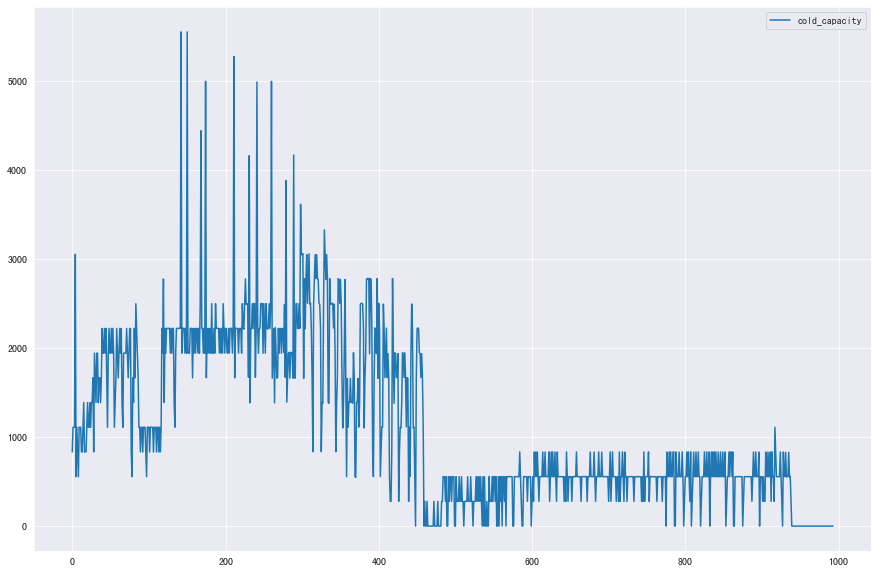

In [32]:
merge_df.plot(y='cold_capacity', figsize=(15, 10))

<AxesSubplot:>

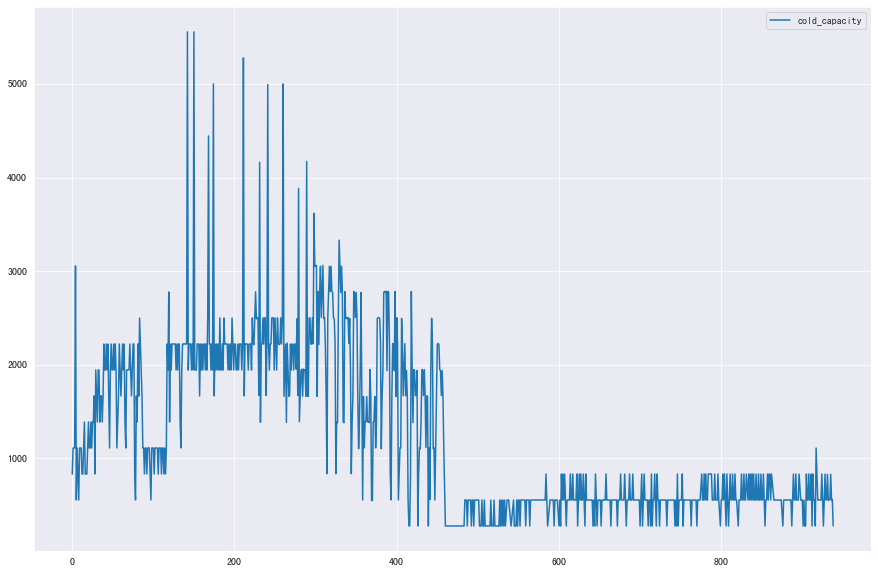

In [33]:
# 删除用冷量为0的时段（没有贡献度）
merge_df = merge_df[merge_df['cold_capacity'] > 0]
merge_df.plot(y='cold_capacity', figsize=(15, 10))

In [34]:
# 读取温湿度数据
db = pymysql.connect(host='8.141.169.219',
                     user='root',
                     password='Zrhdb#2019',
                     port=3307,
                     database='WeiCloudAirDB.V4')
cursor = db.cursor()
sql = "SELECT * FROM Tb_TempHumSensor_History WHERE parm_002=470003957458464 AND parm_003>='2021-01-01'AND parm_003<='2022-08-30'"
cursor.execute(sql)
ws = cursor.fetchall()
db.close()

In [35]:
col = [f[0] for f in cursor.description]
ws_df = pd.DataFrame(list(ws), columns=col)

In [769]:
ws_df

,id,parm_001,parm_002,parm_003,Ths_Parm_001,Ths_Parm_002,Ths_Parm_003,Ths_Parm_004,Ths_Parm_005,Ths_Parm_006,Ths_Parm_007,Ths_Parm_008,Ths_Parm_009,Ths_Parm_010,Ths_Parm_011,Ths_Parm_012,Ths_Parm_013,Ths_Parm_014,Ths_Parm_015
0,473231908870688,2021-02-01 16:42:30,470003957458464,2021-02-01 16:44:33,0.00,0.00,None,None,None,None,None,None,None,None,None,None,None,None,None
1,473232062038049,2021-02-01 16:42:30,470003957458464,2021-02-01 16:49:32,0.00,0.00,None,None,None,None,None,None,None,None,None,None,None,None,None
2,473232215754273,2021-02-01 16:42:30,470003957458464,2021-02-01 16:54:32,0.00,0.00,None,None,None,None,None,None,None,None,None,None,None,None,None
3,473232369369120,2021-02-01 16:42:30,470003957458464,2021-02-01 16:59:32,0.00,0.00,None,None,None,None,None,None,None,None,None,None,None,None,None
4,473232523715617,2021-02-01 16:42:30,470003957458464,2021-02-01 17:04:33,0.00,0.00,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115735,497871578842657,2022-08-12 16:36:38,470003957458464,2022-08-12 16:37:00,33.00,47.30,None,None,None,None,None,None,None,None,None,None,None,None,None
115736,497871732459552,2022-08-12 16:41:44,470003957458464,2022-08-12 16:42:00,32.69,47.69,None,None,None,None,None,None,None,None,None,None,None,None,None
115737,497871886071840,2022-08-12 16:47:02,470003957458464,2022-08-12 16:47:00,32.29,49.20,None,None,None,None,None,None,None,None,None,None,None,None,None
115738,497872039675424,2022-08-12 16:52:06,470003957458464,2022-08-12 16:52:00,32.80,48.18,None,None,None,None,None,None,None,None,None,None,None,None,None


In [37]:
# 时间对齐问题
# 时间取整
weather_info = ws_df.loc[:, ['parm_003', 'Ths_Parm_001', 'Ths_Parm_002']]
weather_info = weather_info.rename(columns={'parm_003': 'date', 'Ths_Parm_001': 'temperature', 'Ths_Parm_002': 'humidity'}).sort_values(['date'])

In [38]:
weather_info

,date,temperature,humidity
0,2021-02-01 16:44:33,0.00,0.00
1,2021-02-01 16:49:32,0.00,0.00
2,2021-02-01 16:54:32,0.00,0.00
3,2021-02-01 16:59:32,0.00,0.00
4,2021-02-01 17:04:33,0.00,0.00
...,...,...,...
115735,2022-08-12 16:37:00,33.00,47.30
115736,2022-08-12 16:42:00,32.69,47.69
115737,2022-08-12 16:47:00,32.29,49.20
115738,2022-08-12 16:52:00,32.80,48.18


In [39]:
merge_df

,date,cold_capacity
0,2021-06-01 15:25:00,833.4
1,2021-06-01 16:25:00,1111.2
2,2021-06-01 17:25:00,1111.2
3,2021-06-01 18:25:00,1111.2
4,2021-06-02 07:25:00,3055.8
...,...,...
934,2022-08-05 14:20:00,560.0
935,2022-08-05 15:20:00,830.0
936,2022-08-05 16:20:00,550.0
937,2022-08-05 17:20:00,560.0


In [40]:
# 构造feature和label
features, labels = [], []
weather_thres = 6
for _, s in merge_df.iterrows():
    date_s = s['date'] - pd.Timedelta(hours=1)
    date_e = s['date']
    temp_df = weather_info[(weather_info['date'] >= date_s) & (weather_info['date'] <= date_e)]
    if temp_df.shape[0] >= weather_thres:
        labels.append(s['cold_capacity'])
        # 特征提取
        temperature = temp_df['temperature'].values
        humidity = temp_df['humidity'].values
        # 提取原值、一阶导和二阶导的均值和标准差（6个特征值）
        temperature_diff = np.diff(temperature)
        temperature_diff2 = np.diff(temperature_diff)
        humidity_diff = np.diff(humidity)
        humidity_diff2 = np.diff(humidity_diff)
        features.append([temperature.mean(), temperature.std(), 
                         temperature_diff.mean(), temperature_diff.std(), 
                         temperature_diff2.mean(), temperature_diff2.std(), 
                         humidity.mean(), humidity.std(), 
                         humidity_diff.mean(), humidity_diff.std(), 
                         humidity_diff2.mean(), humidity_diff2.std()])

In [41]:
len(labels)

883

In [42]:
features, labels = np.array(features), np.array(labels)

In [43]:
# 使用xgboost

In [44]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [45]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=777)

In [46]:
print(x_train.shape)
print(y_train.shape)

(794, 12)
(794,)


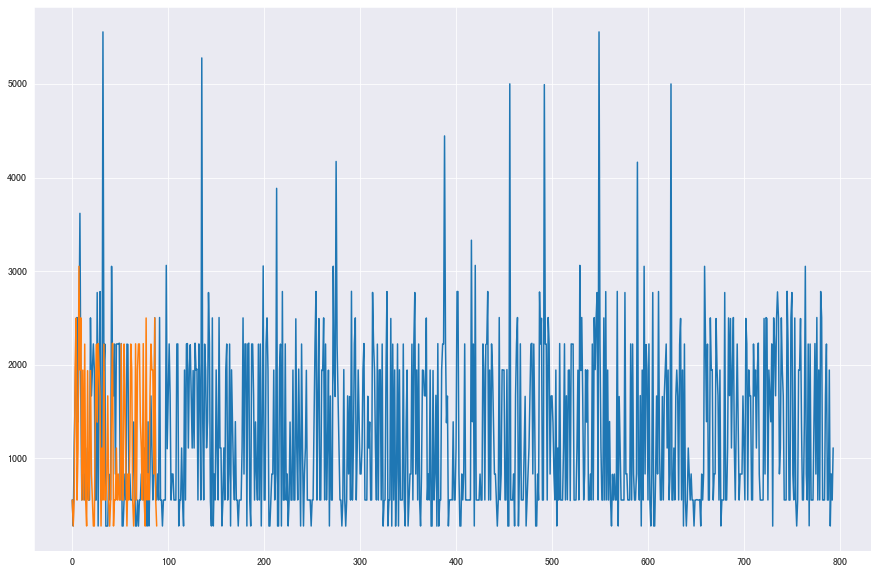

In [47]:
# 数据分析
plt.figure(figsize=(15, 10))
plt.plot(y_train)
plt.plot(y_test)

# 使用hyperopt(贝叶斯优化)+cv完成对xgboost超参数搜索

In [48]:
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from hyperopt.early_stop import no_progress_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [465]:
class HPOpt(object):

    def __init__(self, x_train, y_train, x_test=None, y_test=None):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def run(self, fn_name, space, trials, algo, max_evals, early_stopping=10):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials, 
                          early_stop_fn=no_progress_loss(early_stopping), return_argmin=False)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train, **para['fit_params'])
        cv_loss = -cross_val_score(estimator=reg, X=self.x_train, y=self.y_train, cv=10, 
                                     scoring='neg_root_mean_squared_error')
#         pred = reg.predict(self.x_test)
#         loss = np.sqrt(mean_squared_error(self.y_test, pred)) + cv_loss.mean() + 2 * np.abs(np.mean(self.y_test) - np.mean(pred))
        pred = reg.predict(self.x_train)
        loss = cv_loss.mean() + np.abs(np.mean(self.y_train) - np.mean(pred))
        return {'loss': loss, 'status': STATUS_OK}

In [50]:
# param = {'max_depth': features.shape[1], 'eta': 0.2, 'gamma': 1, 'min_child_weight': 4, 
#          'subsample': 0.5, 'colsample_bytree': 0.5, 'lambda': 1, 'alpha': 1}

In [684]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.quniform('learning_rate', 0.01, 1, 0.01),
    'max_depth':        hp.choice('max_depth', np.arange(3, 13, 1)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 11, 1)),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.1),
    'subsample':        hp.quniform('subsample', 0.1, 1, 0.01),
    'n_estimators':     hp.choice('n_estimators', np.arange(5, 100, 1)),
    'gamma' :           hp.quniform('gamma', 0, 0.5, 0.01),
    'reg_lambda' :      hp.quniform('reg_lambda', 0, 10, 0.1),
    'reg_alpha' :       hp.quniform('reg_alpha', 0, 1, 0.01),
}
xgb_fit_params = {
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params

In [94]:
algo = partial(tpe.suggest, n_startup_jobs=125, n_EI_candidates=50)

In [75]:
obj = HPOpt(x_train, y_train)
xgb_opt = obj.run(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=algo, max_evals=1000, early_stopping=100)

 24%|██████████▉                                  | 243/1000 [02:20<07:18,  1.73trial/s, best loss: 1109.0341366235043]


In [76]:
xgb_opt[0]['reg_params']

{'colsample_bytree': 1.0,
 'gamma': 0.8200000000000001,
 'learning_rate': 0.05,
 'max_depth': 9,
 'min_child_weight': 5,
 'n_estimators': 70,
 'reg_alpha': 0.8,
 'reg_lambda': 0.8,
 'subsample': 0.6900000000000001}

In [77]:
reg = xgb.XGBRegressor(**xgb_opt[0]['reg_params'])
reg.fit(x_train, y_train)
pred = reg.predict(x_test)
pred_train = reg.predict(x_train)
np.sqrt(mean_squared_error(y_test, pred))

468.39925096471586

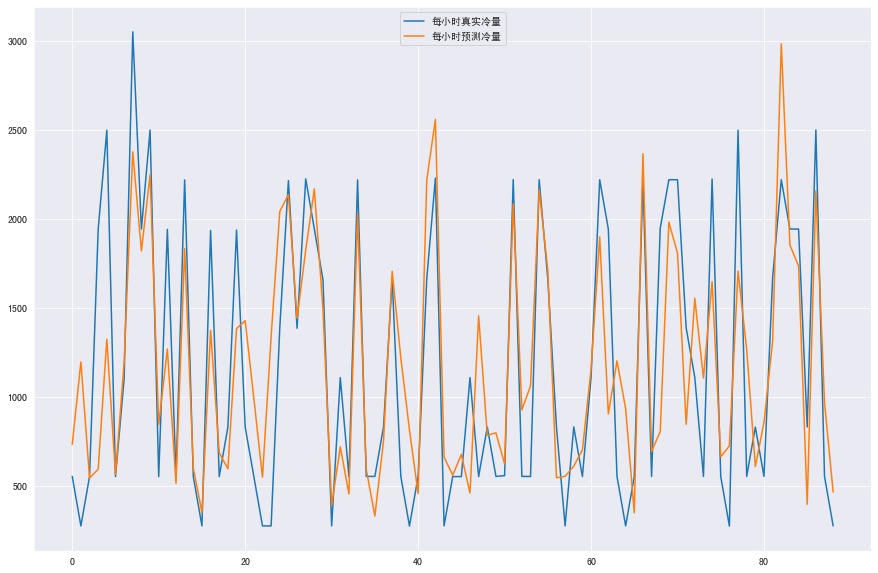

In [78]:
plt.figure(figsize=(15, 10))
plt.plot(y_test, label='每小时真实冷量')
plt.plot(pred, label='每小时预测冷量')
plt.legend()

In [79]:
res_sum = 0
np.abs(np.sum(y_test) - np.sum(pred)) / np.sum(y_test)

0.0003119395566601583

In [80]:
y_test.shape

(89,)

# 模型优化：考虑cop|室内温度|双模型级联预测

In [59]:
# 获取室内温度
db = pymysql.connect(host='8.141.169.219',
                     user='root',
                     password='Zrhdb#2019',
                     port=3307,
                     database='WeiCloudAirDB.V4')
cursor = db.cursor()
sql = "SELECT * FROM Tb_NewWindController_History WHERE `parm_002` IN (470618646962208,470618572902944,470618744251937,470618803815968,470618817306144,470618829469216,470618850919456,470618507798560,470618631240224,470618617578528,470618603848736,470618590059040,470618560459808,470618546182688,470618530813472) AND `parm_003`<'2022-08-30' AND `parm_003`>='2021-01-01'"
cursor.execute(sql)
sn_ws = cursor.fetchall()
db.close()

In [60]:
# 根据获取结果生成dataframe
col = [f[0] for f in cursor.description]
sn_df = pd.DataFrame(list(sn_ws), columns=col)

In [61]:
sn = sn_df[['parm_002', 'parm_003', 'Nc_parm_002', 'Nc_parm_003']].sort_values(['parm_003'])

In [62]:
sn.rename(columns={'parm_002': 'id', 'parm_003': 'date', 'Nc_parm_002': 'current_t', 'Nc_parm_003': 'setting_t'}, inplace=True)

In [152]:
sn

,id,date,current_t,setting_t
0,470618546182688,2021-01-01 00:03:25,21.0,27.5
1,470618817306144,2021-01-01 00:03:25,15.0,25.5
2,470618572902944,2021-01-01 00:03:25,18.5,27.5
3,470618590059040,2021-01-01 00:03:25,20.5,27.0
4,470618530813472,2021-01-01 00:03:25,20.5,27.0
...,...,...,...,...
796000,470618546182688,2022-08-12 17:00:00,24.5,24.0
795999,470618530813472,2022-08-12 17:00:00,28.5,5.0
795998,470618507798560,2022-08-12 17:00:00,28.5,5.0
796003,470618617578528,2022-08-12 17:00:00,29.0,11.5


In [153]:
# 取室温大于20度的数据
print(sn.shape)
use_sn = sn[sn['current_t'] >= 20]
use_sn.shape

(796011, 4)


(304440, 4)

In [164]:
use_sn

,id,date,current_t,setting_t
0,470618546182688,2021-01-01 00:03:25,21.0,27.5
3,470618590059040,2021-01-01 00:03:25,20.5,27.0
4,470618530813472,2021-01-01 00:03:25,20.5,27.0
10,470618603848736,2021-01-01 00:03:30,20.0,24.0
17,470618590059040,2021-01-01 00:13:22,20.5,27.0
...,...,...,...,...
796001,470618560459808,2022-08-12 17:00:00,23.0,5.0
796000,470618546182688,2022-08-12 17:00:00,24.5,24.0
795999,470618530813472,2022-08-12 17:00:00,28.5,5.0
795998,470618507798560,2022-08-12 17:00:00,28.5,5.0


In [165]:
# 优化特征构造
features_opt, labels_opt = [], []
weather_thres = 6
sn_thres = 3
for _, s in merge_df.iterrows():
    date_s = s['date'] - pd.Timedelta(hours=1)
    date_e = s['date']
    weather_df = weather_info[(weather_info['date'] >= date_s) & (weather_info['date'] <= date_e)]
    sn_df = use_sn[(use_sn['date'] >= date_s) & (use_sn['date'] <= date_e)]
    if weather_df.shape[0] >= weather_thres and sn_df.shape[0] >= sn_thres:
        labels_opt.append(s['cold_capacity'])
        # 特征提取
        temperature = weather_df['temperature'].values
        humidity = weather_df['humidity'].values
        sn_temperature = sn_df['current_t'].values
        # 提取原值、一阶导和二阶导的均值和标准差（6个特征值）
        temperature_diff = np.diff(temperature)
        temperature_diff2 = np.diff(temperature_diff)
        humidity_diff = np.diff(humidity)
        humidity_diff2 = np.diff(humidity_diff)
        features_opt.append([temperature.mean(), temperature.std(), 
                         temperature_diff.mean(), temperature_diff.std(), 
                         temperature_diff2.mean(), temperature_diff2.std(), 
                         humidity.mean(), humidity.std(), 
                         humidity_diff.mean(), humidity_diff.std(), 
                         humidity_diff2.mean(), humidity_diff2.std(), np.mean(sn_temperature)])

In [166]:
features_opt, labels_opt = np.array(features_opt), np.array(labels_opt)

In [169]:
x_train_opt, x_test_opt, y_train_opt, y_test_opt = train_test_split(features_opt, labels_opt, test_size=0.1, random_state=666)
obj = HPOpt(x_train_opt, y_train_opt)
xgb_opt = obj.run(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=algo, max_evals=1000, early_stopping=100)

 13%|█████▉                                       | 132/1000 [00:34<03:49,  3.78trial/s, best loss: 438.30916919283726]


In [170]:
xgb_opt[0]['reg_params']

{'colsample_bytree': 0.78,
 'gamma': 0.36,
 'learning_rate': 0.15,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 95,
 'reg_alpha': 1.7000000000000002,
 'reg_lambda': 1.8,
 'subsample': 0.9400000000000001}

In [171]:
reg = xgb.XGBRegressor(**xgb_opt[0]['reg_params'])
reg.fit(x_train_opt, y_train_opt)
pred = reg.predict(x_test_opt)
pred_train = reg.predict(x_train_opt)
np.sqrt(mean_squared_error(y_test_opt, pred))

172.03439362911476

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

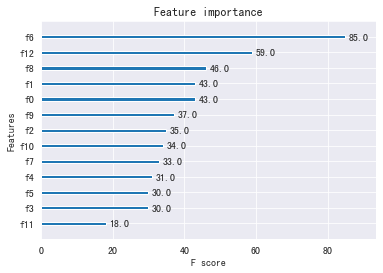

In [172]:
xgb.plot_importance(reg)

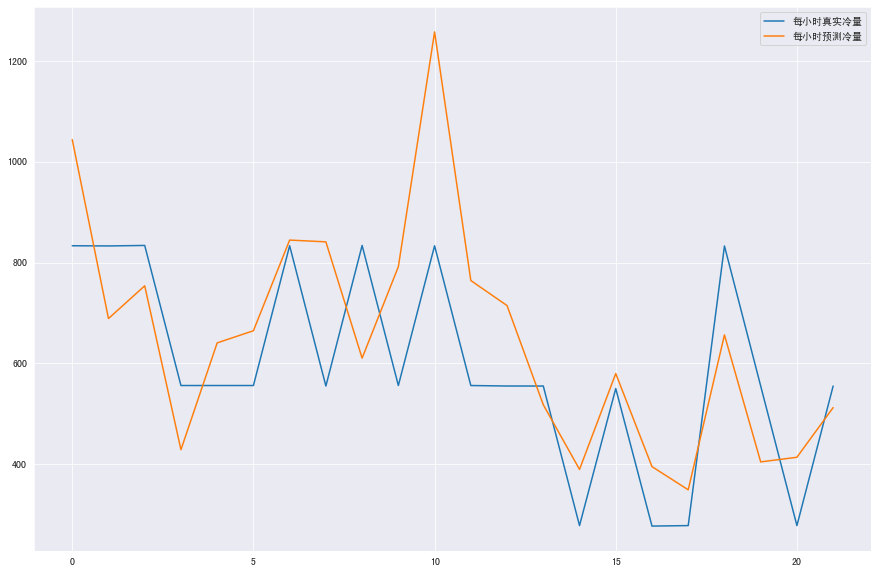

In [173]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_opt, label='每小时真实冷量')
plt.plot(pred, label='每小时预测冷量')
plt.legend()

# ！！！！！！！！！！！！

# 多粒度预测（xgboost+核密度估计+马尔可夫链+蒙特卡洛采样（M-H采样））

In [196]:
use_df = use_df[use_df['date'].dt.month.isin([6, 7, 8])]
use_df

,date,cold_capacity,cold_capacity_diff,day,hour
0,2021-06-01 14:25:00,6.995000e+05,NaN,2021-06-01,14
1,2021-06-01 14:30:00,6.997778e+05,277.8,2021-06-01,14
2,2021-06-01 14:35:00,6.997778e+05,0.0,2021-06-01,14
3,2021-06-01 14:40:00,6.997778e+05,0.0,2021-06-01,14
4,2021-06-01 14:45:00,6.997778e+05,0.0,2021-06-01,14
...,...,...,...,...,...
62955,2022-08-12 16:35:00,1.015761e+10,0.0,2022-08-12,16
62956,2022-08-12 16:40:00,1.015761e+10,0.0,2022-08-12,16
62957,2022-08-12 16:45:00,1.015761e+10,0.0,2022-08-12,16
62958,2022-08-12 16:50:00,1.015761e+10,0.0,2022-08-12,16


<AxesSubplot:>

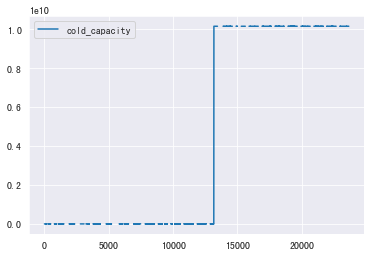

In [216]:
test = use_df.copy()
test.index = np.arange(len(test))
# test['cold_capacity'] = test['cold_capacity'].interpolate(kind='spline', order=2)
# test['cold_capacity_diff'] = test['cold_capacity'].diff()
test.plot(y='cold_capacity')

In [219]:
test['cold_capacity_diff'].first_valid_index()

1

In [ ]:
# # 删去差分后异常的点
# print('filter before: ', data_df.shape[0])
# iter_max_counts = 10
# bf = data_df.shape[0]
# for i in range(iter_max_counts):
#     diff_use_idx = sigma3(data_df['cold_capacity_diff'].values)
#     filter_idx = np.setdiff1d(np.arange(bf), diff_use_idx)
#     data_df.iloc[filter_idx, [1, 2]] = np.nan
#     print('filter: ', len(filter_idx))
#     if len(filter_idx) == 0:
#         break
# data_df

In [220]:
# 理论上早七晚七每五分钟共有144个点
valid_counts = 144

In [236]:
# 按天合并
def merge_by_day(df):
    res = defaultdict(list)
    g = df.groupby(['day'])
    for d, sub_df in g:
        # 去掉开头和结尾的nan值
        first_idx = sub_df['cold_capacity'].first_valid_index()
        last_idx = sub_df['cold_capacity'].last_valid_index()
        if first_idx is None or last_idx is None:
            continue
        sub_df = sub_df.loc[first_idx: last_idx]
        # 计算冷量
        cc = sub_df.iloc[-1]['cold_capacity'] - sub_df.iloc[0]['cold_capacity']
        current_counts = len(sub_df)
        if cc == 0 or current_counts / valid_counts <= 0.5:
            continue
        res['date'].append(d)
        res['cold_capacity'].append(cc / current_counts * valid_counts)
    return pd.DataFrame.from_dict(res)

In [237]:
merge_day_df = merge_by_day(test)

In [685]:
merge_day_df

,date,cold_capacity
0,2021-06-02,11668.200000
1,2021-06-04,13334.400000
2,2021-06-07,17501.800000
3,2021-06-09,21668.000000
4,2021-06-10,22224.000000
...,...,...
92,2022-08-01,6389.000000
93,2022-08-02,4849.454545
94,2022-08-03,6390.000000
95,2022-08-04,6667.000000


In [246]:
merge_day_df['date'] = pd.to_datetime(merge_day_df['date'])
merge_day_df

,date,cold_capacity
0,2021-06-02,11668.200000
1,2021-06-04,13334.400000
2,2021-06-07,17501.800000
3,2021-06-09,21668.000000
4,2021-06-10,22224.000000
...,...,...
92,2022-08-01,6389.000000
93,2022-08-02,4849.454545
94,2022-08-03,6390.000000
95,2022-08-04,6667.000000


In [254]:
# 温湿度时间取整
weather_info['date'] = weather_info['date'].dt.round('5min')
use_sn['date'] = use_sn['date'].dt.round('10min')

C:\Users\zhangym\AppData\Local\Temp\ipykernel_15760\1079380734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_sn['date'] = use_sn['date'].dt.round('10min')


In [257]:
# 确保温湿度时间连续
supple_dates = pd.DataFrame(pd.date_range(start=weather_info['date'].min(), end=weather_info['date'].max(), freq='5min'), columns=['date'])
weather_info = pd.merge(supple_dates, weather_info, on='date', how='left')
weather_info = weather_info.sort_values(by=['date'])

,date,temperature,humidity
0,2021-02-01 16:45:00,0.00,0.00
1,2021-02-01 16:50:00,0.00,0.00
2,2021-02-01 16:55:00,0.00,0.00
3,2021-02-01 17:00:00,0.00,0.00
4,2021-02-01 17:05:00,0.00,0.00
...,...,...,...
162039,2022-08-12 16:35:00,33.00,47.30
162040,2022-08-12 16:40:00,32.69,47.69
162041,2022-08-12 16:45:00,32.29,49.20
162042,2022-08-12 16:50:00,32.80,48.18


In [258]:
supple_dates = pd.DataFrame(pd.date_range(start=use_sn['date'].min(), end=use_sn['date'].max(), freq='10min'), columns=['date'])
use_sn = pd.merge(supple_dates, use_sn, on='date', how='left')
use_sn = use_sn.sort_values(by=['date'])
use_sn

,date,id,current_t,setting_t
0,2021-01-01 00:00:00,4.706185e+14,21.0,27.5
1,2021-01-01 00:00:00,4.706186e+14,20.5,27.0
2,2021-01-01 00:00:00,4.706185e+14,20.5,27.0
3,2021-01-01 00:00:00,4.706186e+14,20.0,24.0
4,2021-01-01 00:10:00,4.706186e+14,20.5,27.0
...,...,...,...,...
353612,2022-08-12 17:00:00,4.706186e+14,27.5,5.0
353613,2022-08-12 17:00:00,4.706186e+14,23.0,5.0
353614,2022-08-12 17:00:00,4.706185e+14,24.5,24.0
353615,2022-08-12 17:00:00,4.706185e+14,28.5,5.0


In [795]:
weather_info.shape

(162044, 3)

In [796]:
use_sn.shape

(353618, 4)

In [686]:
use_sn['date'].drop_duplicates().values

array(['2021-01-01T00:00:00.000000000', '2021-01-01T00:10:00.000000000',
       '2021-01-01T00:20:00.000000000', ...,
       '2022-08-12T16:40:00.000000000', '2022-08-12T16:50:00.000000000',
       '2022-08-12T17:00:00.000000000'], dtype='datetime64[ns]')

In [390]:
# 优化特征构造
features_opt, labels_opt = [], []
feature_idx = []
weather_count_thres = 12
sn_count_thres = 6
for idx, s in merge_day_df.iterrows():
    date_s = s['date'] - pd.Timedelta(days=1)
    date_e = s['date']
    
    weather_df = weather_info[(weather_info['date'] >= date_s) & (weather_info['date'] <= date_e)]
    sn_df = use_sn[(use_sn['date'] >= date_s) & (use_sn['date'] <= date_e)]
    
    # 去掉头和尾的nan值
    first_idx = weather_df[['temperature', 'humidity']].first_valid_index()
    last_idx = weather_df[['temperature', 'humidity']].last_valid_index()
    if first_idx is None or last_idx is None:
        continue
    weather_df = weather_df.loc[first_idx: last_idx]
    
    # 去掉头和尾的nan值
    first_idx = sn_df['current_t'].first_valid_index()
    last_idx = sn_df['current_t'].last_valid_index()
    if first_idx is None or last_idx is None:
        continue
    sn_df = sn_df.loc[first_idx: last_idx]
    
    # 判断中间的nan值个数是否大于非nan值个数的0.5倍
#     weather_df_valid_counts = weather_df[['temperature', 'humidity']].dropna().shape[0]
#     weather_df_nan_counts = weather_df.shape[0] - weather_df_valid_counts
#     sn_df_valid_counts = sn_df['current_t'].dropna().shape[0]
#     sn_df_nan_counts = sn_df.shape[0] - sn_df_valid_counts
#     if weather_df_nan_counts / weather_df_valid_counts > 0.5 or sn_df_nan_counts / sn_df_valid_counts > 0.5:
#         continue
    
    if weather_df.shape[0] < weather_count_thres or sn_df.shape[0] < sn_count_thres:
        continue
    
    # 中间的nan值进行插值
    weather_df[['temperature', 'humidity']] = weather_df[['temperature', 'humidity']].interpolate(kind='spline', order=3)
    sn_df['current_t'] = sn_df['current_t'].interpolate(kind='spline', order=2)
    labels_opt.append(s['cold_capacity'])
    # 特征提取
    temperature = weather_df['temperature'].values
    humidity = weather_df['humidity'].values
    sn_temperature = sn_df['current_t'].values
    # 提取原值、一阶导和二阶导的均值和标准差
    temperature_diff = np.diff(temperature)
    temperature_diff2 = np.diff(temperature_diff)
    humidity_diff = np.diff(humidity)
    humidity_diff2 = np.diff(humidity_diff)
    features_opt.append([temperature.mean(), temperature.std(), 
                         temperature_diff.mean(), temperature_diff.std(), 
                         temperature_diff2.mean(), temperature_diff2.std(), 
                         humidity.mean(), humidity.std(), 
                         humidity_diff.mean(), humidity_diff.std(), 
                         humidity_diff2.mean(), humidity_diff2.std(), 
                         sn_temperature.mean()])
    feature_idx.append(idx)

In [794]:
features_opt.__len__()

65

In [707]:
# features和labels转成dataframe，以便获取索引
feature_columns = ['t_mean', 't_std', 't_diff_mean', 't_diff_std', 't_diff2_mean', 't_diff2_std', 
                   'h_mean', 'h_std', 'h_diff_mean', 'h_diff_std', 'h_diff2_mean', 'h_diff2_std', 'sn_t_mean']
features_df = pd.DataFrame(features_opt, columns=feature_columns)
labels_df = pd.Series(labels_opt)

In [783]:
features_df

,t_mean,t_std,t_diff_mean,t_diff_std,t_diff2_mean,t_diff2_std,h_mean,h_std,h_diff_mean,h_diff_std,h_diff2_mean,h_diff2_std,sn_t_mean
0,30.570254,1.109261,0.015641,0.806389,0.004052,1.424151,31.317966,0.125560,0.002051,0.036621,0.000259,0.037725,20.896825
1,24.940058,1.877959,-0.009532,0.500573,0.000529,0.814698,18.461860,3.704645,-0.015322,0.651206,-0.006118,1.027038,25.580882
2,26.502266,4.867840,0.004201,0.676772,0.000348,1.128901,30.712872,8.488749,0.027431,1.158019,0.001010,1.820677,109.134615
3,24.329723,4.288866,0.015799,0.668091,-0.000035,1.043776,55.816125,13.101921,-0.031007,1.550699,-0.000906,2.294046,129.480634
4,21.200588,3.035559,-0.023472,0.344525,-0.000697,0.497762,66.631522,10.410672,0.058924,1.241441,0.002857,1.699086,117.375954
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,30.123983,3.323011,0.002457,0.733832,-0.001042,1.126625,37.637155,17.966001,0.034637,1.934446,-0.006250,2.698197,31.483852
61,32.084598,4.767807,0.015040,0.706580,0.000891,1.152853,37.074759,11.292031,0.016532,1.571218,0.004413,2.275306,29.437148
62,34.538813,2.190378,-0.034843,0.526193,0.000063,0.860598,48.049875,5.264180,0.033836,1.213431,-0.001203,1.945884,28.385057
63,33.164083,3.189361,0.000278,0.517291,-0.000418,0.803149,43.193183,8.981369,0.012083,1.197930,-0.000627,1.656907,29.327286


In [785]:
labels_df

0     0.466765
1     0.533419
2     0.700128
3     0.866789
4     0.889031
        ...   
60    0.255580
61    0.193994
62    0.255620
63    0.266701
64    0.266781
Length: 65, dtype: float64

In [708]:
# 对label进行归一化
baseline = labels_df.quantile(0.75)
labels_df = labels_df / baseline

In [710]:
x_train_opt, x_test_opt, y_train_opt, y_test_opt = train_test_split(features_df, labels_df, test_size=0.1, random_state=666)
# 获取split后train和test的索引
train_idx = y_train_opt.index.values
test_idx = y_test_opt.index.values

In [711]:
obj = HPOpt(x_train_opt.values, y_train_opt.values)
xgb_opt = obj.run(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=algo, max_evals=1000, early_stopping=100)
reg = xgb.XGBRegressor(**xgb_opt[0]['reg_params'])
reg.fit(x_train_opt.values, y_train_opt.values)
pred = reg.predict(x_test_opt.values)
pred_train = reg.predict(x_train_opt.values)
np.sqrt(mean_squared_error(y_test_opt.values, pred))

 33%|██████████████▍                             | 329/1000 [01:30<03:05,  3.62trial/s, best loss: 0.19563234127065254]


0.11375323118248075

In [712]:
xgb_opt[0]['reg_params']

{'colsample_bytree': 0.6000000000000001,
 'gamma': 0.18,
 'learning_rate': 1.0,
 'max_depth': 12,
 'min_child_weight': 1,
 'n_estimators': 73,
 'reg_alpha': 0.11,
 'reg_lambda': 2.9000000000000004,
 'subsample': 0.98}

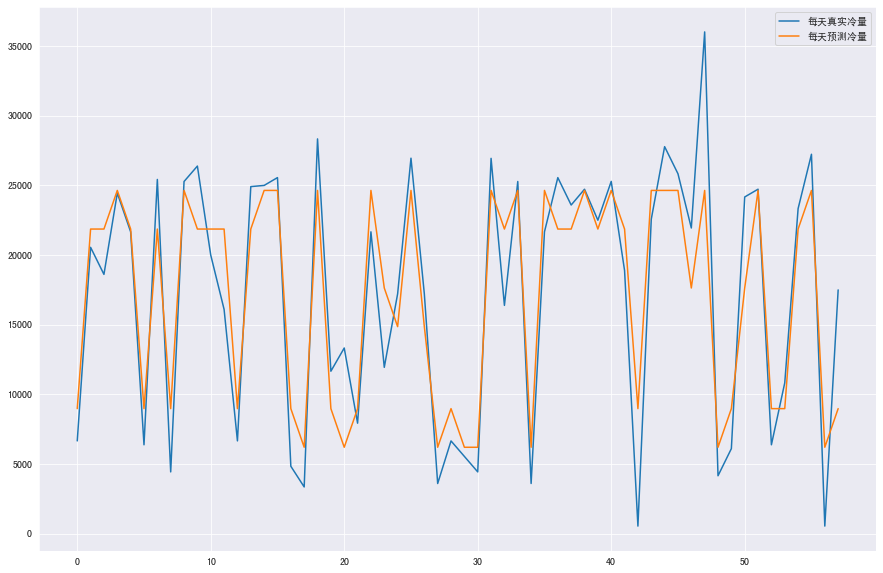

In [713]:
plt.figure(figsize=(15, 10))
plt.plot(y_train_opt.values * baseline, label='每天真实冷量')
plt.plot(pred_train * baseline, label='每天预测冷量')
plt.legend()

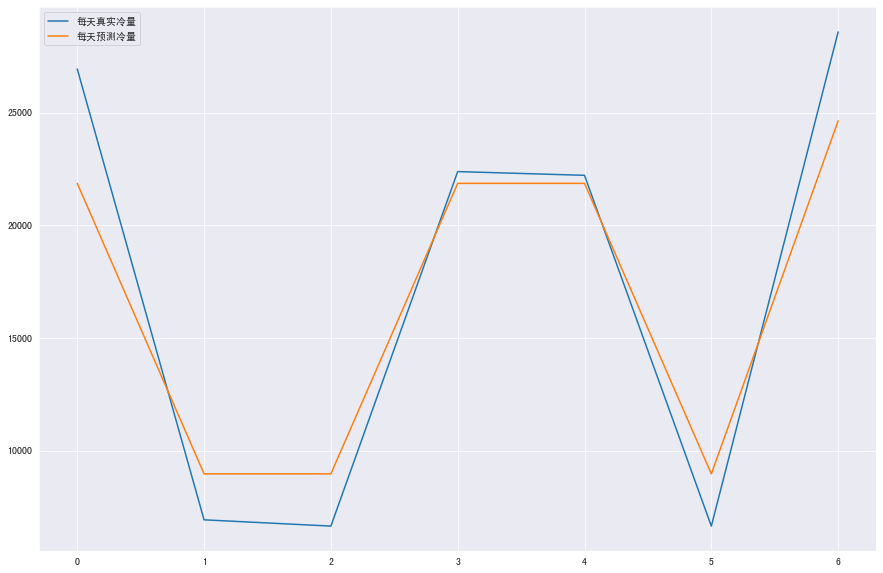

In [714]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_opt.values * baseline, label='每天真实冷量')
plt.plot(pred * baseline, label='每天预测冷量')
plt.legend()

In [811]:
k = pd.DataFrame(pd.date_range(start='2022-01-01', end='2022-01-05', freq='min'), columns=['a'])
k['a'].dt.hour

0        0
1        0
2        0
3        0
4        0
        ..
5756    23
5757    23
5758    23
5759    23
5760     0
Name: a, Length: 5761, dtype: int64

In [325]:
# 按小时合并，统计每小时占总量的占比
valid_hour_counts = 12
def merge_by_hour(df):
    res = defaultdict(list)
    g = df.groupby(['day', 'hour'])
    for d, sub_df in g:
        # 去掉开头和结尾的nan值
        first_idx = sub_df['cold_capacity'].first_valid_index()
        last_idx = sub_df['cold_capacity'].last_valid_index()
        if first_idx is None or last_idx is None:
            continue
        sub_df = sub_df.loc[first_idx: last_idx]
        # 计算冷量
        cc = sub_df.iloc[-1]['cold_capacity'] - sub_df.iloc[0]['cold_capacity']
        current_counts = len(sub_df)
        if cc == 0 or current_counts / valid_hour_counts <= 0.5:
            continue
        res['day'].append(d[0])
        res['hour'].append(d[1])
        res['cold_capacity'].append(cc / current_counts * valid_hour_counts)
    return pd.DataFrame.from_dict(res)

In [406]:
merge_hour_df = merge_by_hour(test)

In [407]:
merge_hour_df['day'] = pd.to_datetime(merge_hour_df['day'])
merge_hour_df

,day,hour,cold_capacity
0,2021-06-01,14,952.457143
1,2021-06-01,15,1111.200000
2,2021-06-01,16,1111.200000
3,2021-06-01,17,833.400000
4,2021-06-01,18,555.600000
...,...,...,...
1042,2022-08-05,13,560.000000
1043,2022-08-05,14,550.000000
1044,2022-08-05,15,560.000000
1045,2022-08-05,16,550.000000


In [328]:
merge_day_df

,date,cold_capacity
0,2021-06-02,11668.200000
1,2021-06-04,13334.400000
2,2021-06-07,17501.800000
3,2021-06-09,21668.000000
4,2021-06-10,22224.000000
...,...,...
92,2022-08-01,6389.000000
93,2022-08-02,4849.454545
94,2022-08-03,6390.000000
95,2022-08-04,6667.000000


In [329]:
merge_hour_df['hour'].drop_duplicates().values

array([14, 15, 16, 17, 18,  7,  8,  9, 10, 11, 12, 13], dtype=int64)

In [408]:
def ratio_cal(s):
    day_cc = merge_day_df[merge_day_df['date'] == s['day']]['cold_capacity'].values
    res = np.nan
    if day_cc.shape[0] > 0:
        day_cc = day_cc[0]
        res = s['cold_capacity'] / day_cc
    return res
# 统计每小时占比
merge_hour_df['cold_ratio'] = merge_hour_df.apply(ratio_cal, axis=1)

In [409]:
merge_hour_df = merge_hour_df[~pd.isnull(merge_hour_df['cold_ratio'])]
merge_hour_df

,day,hour,cold_capacity,cold_ratio
5,2021-06-02,7,1111.200000,0.095233
6,2021-06-02,8,555.600000,0.047617
7,2021-06-02,9,277.800000,0.023808
8,2021-06-02,10,909.163636,0.077918
9,2021-06-02,11,1111.200000,0.095233
...,...,...,...,...
1042,2022-08-05,13,560.000000,0.083971
1043,2022-08-05,14,550.000000,0.082471
1044,2022-08-05,15,560.000000,0.083971
1045,2022-08-05,16,550.000000,0.082471


In [410]:
merge_hour_df['date'] = merge_hour_df.apply(lambda s: s['day'] + pd.Timedelta(hours=s['hour']), axis=1)
merge_hour_df

C:\Users\zhangym\AppData\Local\Temp\ipykernel_15760\116486936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_hour_df['date'] = merge_hour_df.apply(lambda s: s['day'] + pd.Timedelta(hours=s['hour']), axis=1)


,day,hour,cold_capacity,cold_ratio,date
5,2021-06-02,7,1111.200000,0.095233,2021-06-02 07:00:00
6,2021-06-02,8,555.600000,0.047617,2021-06-02 08:00:00
7,2021-06-02,9,277.800000,0.023808,2021-06-02 09:00:00
8,2021-06-02,10,909.163636,0.077918,2021-06-02 10:00:00
9,2021-06-02,11,1111.200000,0.095233,2021-06-02 11:00:00
...,...,...,...,...,...
1042,2022-08-05,13,560.000000,0.083971,2022-08-05 13:00:00
1043,2022-08-05,14,550.000000,0.082471,2022-08-05 14:00:00
1044,2022-08-05,15,560.000000,0.083971,2022-08-05 15:00:00
1045,2022-08-05,16,550.000000,0.082471,2022-08-05 16:00:00


In [348]:
# 核密度估计
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm

In [734]:
# M-H采样
need_iter = 2000
need_samples = 10
# 计算条件概率Q(i,j): 选择的马尔可夫链状态转移矩阵Q(i,j)的条件转移概率是以i为均值,方差1的正态分布在位置j的值

In [778]:
merge_hour_df

,day,hour,cold_capacity,cold_ratio,date
5,2021-06-02,7,1111.200000,0.095233,2021-06-02 07:00:00
6,2021-06-02,8,555.600000,0.047617,2021-06-02 08:00:00
7,2021-06-02,9,277.800000,0.023808,2021-06-02 09:00:00
8,2021-06-02,10,909.163636,0.077918,2021-06-02 10:00:00
9,2021-06-02,11,1111.200000,0.095233,2021-06-02 11:00:00
...,...,...,...,...,...
1042,2022-08-05,13,560.000000,0.083971,2022-08-05 13:00:00
1043,2022-08-05,14,550.000000,0.082471,2022-08-05 14:00:00
1044,2022-08-05,15,560.000000,0.083971,2022-08-05 15:00:00
1045,2022-08-05,16,550.000000,0.082471,2022-08-05 16:00:00


KernelDensity(bandwidth=0.009990990990990992)
KernelDensity(bandwidth=0.01298798798798799)
KernelDensity(bandwidth=0.010989989989989991)
KernelDensity(bandwidth=0.004995995995995996)
KernelDensity(bandwidth=0.005994994994994995)
KernelDensity(bandwidth=0.007992992992992994)
KernelDensity(bandwidth=0.004995995995995996)
KernelDensity(bandwidth=0.009990990990990992)
KernelDensity(bandwidth=0.006494494494494495)
KernelDensity(bandwidth=0.009491491491491491)
KernelDensity(bandwidth=0.01148948948948949)
KernelDensity(bandwidth=0.02197897897897898)


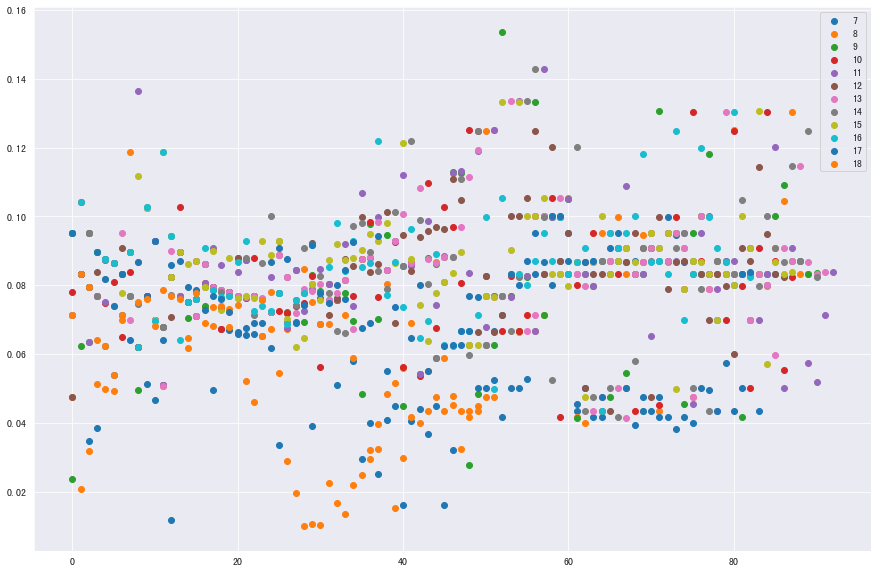

In [735]:
kde = KernelDensity(kernel='gaussian')
sample_ratio = {}
parameters = {'bandwidth': np.linspace(0.001, 0.5, 1000)}
clf = GridSearchCV(kde, parameters)
g = merge_hour_df.groupby(['hour'])
plt.figure(figsize=(15, 10))
# 记录每时刻给出的采样值
for h, df in g:
    ratio_arr = df['cold_ratio'].values
    # 过滤异常点
    ratio_arr = ratio_arr[sigma3(ratio_arr)]
    plt.scatter(np.arange(len(ratio_arr)), ratio_arr, label=h)
    model_input = ratio_arr.reshape(-1, 1)
    clf.fit(model_input)
    best_model = clf.best_estimator_
    print(best_model)
    best_model.fit(model_input)
    # 得到概率密度函数
    kde_sample = best_model.score_samples
    # 采样
    current_x = 0
    sub_sample = []
    for i in range(need_iter * 2):
        if len(sub_sample) > need_samples:
            break
        next_x = norm.rvs(loc=current_x, scale=1, size=1)[0]
        alpha = min(1, np.exp(kde_sample([[next_x]]))[0] / np.exp(kde_sample([[current_x]]))[0])
        u = np.random.uniform(0, 1)
        if u < alpha:
            current_x = next_x
            if i >= need_iter:
                sub_sample.append(current_x)
    sample_ratio[h] = sub_sample
plt.legend()

In [640]:
# 特征构造（小时级）
features_hour, labels_hour = [], []
feature_hour_idx = []
for idx, s in merge_hour_df.iterrows():
    date_s = s['date'] - pd.Timedelta(hours=1)
    date_e = s['date']
    weather_df = weather_info[(weather_info['date'] >= date_s) & (weather_info['date'] <= date_e)].dropna(subset=['temperature', 'humidity'])
    sn_df = use_sn[(use_sn['date'] >= date_s) & (use_sn['date'] <= date_e)].dropna(subset=['current_t'])
    if weather_df.shape[0] < 1 or sn_df.shape[0] < 1:
        continue
    labels_hour.append(s['cold_ratio'])
    # 特征提取
    temperature = weather_df['temperature'].values
    humidity = weather_df['humidity'].values
    sn_temperature = sn_df['current_t'].values
#     temperature_diff = np.diff(temperature)
#     temperature_diff2 = np.diff(temperature_diff)
#     humidity_diff = np.diff(humidity)
#     humidity_diff2 = np.diff(humidity_diff)
#     features_hour.append([temperature.mean(), temperature.std(), 
#                          temperature_diff.mean(), temperature_diff.std(), 
#                          temperature_diff2.mean(), temperature_diff2.std(), 
#                          humidity.mean(), humidity.std(), 
#                          humidity_diff.mean(), humidity_diff.std(), 
#                          humidity_diff2.mean(), humidity_diff2.std(), 
#                          sn_temperature.mean()])
    # 根据实际条件，只能取均值
    features_hour.append([temperature.mean(), humidity.mean(), sn_temperature.mean()])
    feature_hour_idx.append(idx)

In [641]:
features_hour.__len__()

487

In [715]:
# features和labels转成dataframe，以便获取索引
feature_columns = ['t_mean', 'h_mean', 'sn_t_mean']
# feature_columns = ['t_mean', 't_std', 't_diff_mean', 't_diff_std', 't_diff2_mean', 't_diff2_std', 
#                    'h_mean', 'h_std', 'h_diff_mean', 'h_diff_std', 'h_diff2_mean', 'h_diff2_std', 'sn_t_mean']
features_hour_df = pd.DataFrame(features_hour, columns=feature_columns)
labels_hour_df = pd.Series(labels_hour)

In [716]:
# label归一化
baseline_hour = labels_hour_df.quantile(0.75)
labels_hour_df = labels_hour_df / baseline_hour
labels_hour_df

0      1.088094
1      0.544047
2      0.272023
3      0.890258
4      1.088094
         ...   
482    0.959412
483    0.942280
484    0.959412
485    0.942280
486    0.959412
Length: 487, dtype: float64

In [717]:
x_train_hour, x_test_hour, y_train_hour, y_test_hour = train_test_split(features_hour_df, labels_hour_df, test_size=0.1, random_state=666)
# 获取split后train和test的索引
train_hour_idx = y_train_hour.index.values
test_hour_idx = y_test_hour.index.values

In [718]:
print(x_train_hour.shape)
print(x_test_hour.shape)

(438, 3)
(49, 3)


In [719]:
obj = HPOpt(x_train_hour.values, y_train_hour.values)
xgb_opt = obj.run(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=algo, max_evals=1000, early_stopping=100)
params = xgb_opt[0]['reg_params']
# gamma对模型的结果影响很大！！！
reg = xgb.XGBRegressor(**params)
# reg = xgb.XGBRegressor(reg_lambda=8)
reg.fit(x_train_hour.values, y_train_hour.values)
pred_hour = reg.predict(x_test_hour.values)
pred_train = reg.predict(x_train_hour.values)
print(np.sqrt(mean_squared_error(y_train_hour.values, pred_train)))
print(np.sqrt(mean_squared_error(y_test_hour.values, pred_hour)))

 11%|████▋                                       | 106/1000 [00:30<04:21,  3.42trial/s, best loss: 0.37203909127918894]
0.23709430295668435
0.33778148636068484


In [723]:
xgb_opt[0]['reg_params']

{'colsample_bytree': 1.0,
 'gamma': 0.29,
 'learning_rate': 0.55,
 'max_depth': 4,
 'min_child_weight': 7,
 'n_estimators': 92,
 'reg_alpha': 0.68,
 'reg_lambda': 4.1000000000000005,
 'subsample': 0.68}

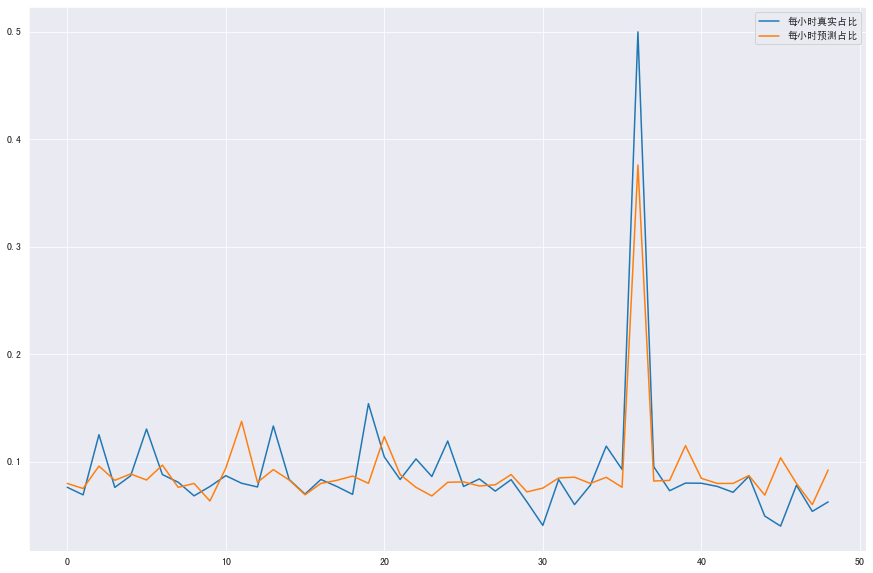

In [724]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_hour.values * baseline_hour, label='每小时真实占比')
plt.plot(pred_hour * baseline_hour, label='每小时预测占比')
plt.legend()

In [743]:
# 叠加采样比例，得到计算结果
test_hour_df = merge_hour_df.loc[feature_hour_idx].iloc[test_hour_idx]

In [742]:
sample_ratio.keys()

dict_keys([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [746]:
test_hour_df['pre_ratio'] = pred_hour * baseline_hour
test_hour_df['sample_ratio'] = test_hour_df['hour'].apply(lambda x: np.mean(sample_ratio[x]))

In [754]:
test_hour_df['res_ratio'] = test_hour_df['pre_ratio'] * 2 / 3  + test_hour_df['sample_ratio'] / 3

<AxesSubplot:>

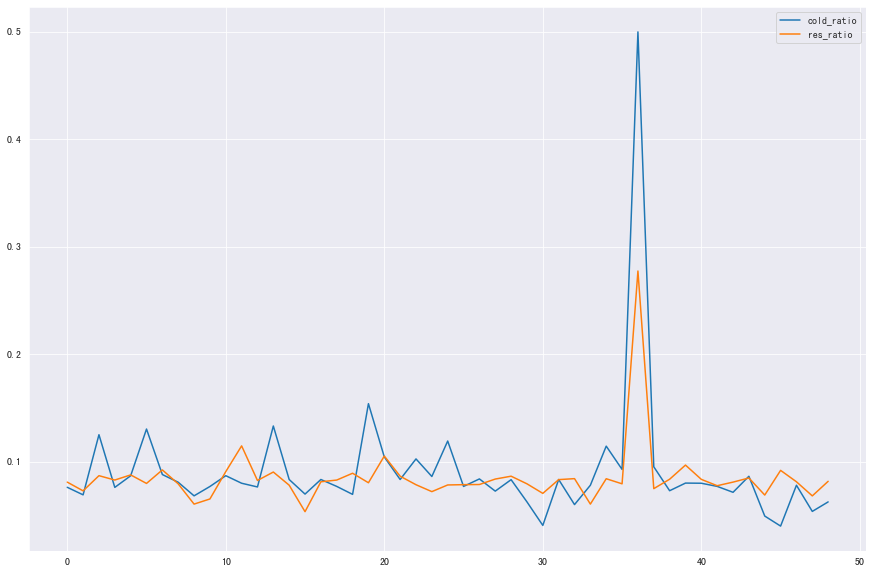

In [758]:
test_hour_df.plot(y=['cold_ratio', 'res_ratio'], figsize=(15, 10), use_index=False) 

In [629]:
# 结果写入数据库中(代码整合)
obj = HPOpt(features_df.values, labels_df.values)
xgb_opt = obj.run(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=algo, max_evals=1000, early_stopping=100)
reg = xgb.XGBRegressor(**xgb_opt[0]['reg_params'])
# reg = xgb.XGBRegressor()
reg.fit(features_df.values, labels_df.values)
pred_all = reg.predict(features_df.values)

 10%|████▊                                         | 104/1000 [00:22<03:12,  4.66trial/s, best loss: 5307.407996770888]


In [630]:
xgb_opt[0]['reg_params']

{'colsample_bytree': 0.9,
 'learning_rate': 0.4,
 'max_depth': 11,
 'min_child_weight': 4,
 'n_estimators': 91,
 'reg_alpha': 0.07,
 'reg_lambda': 5.9,
 'subsample': 0.66}

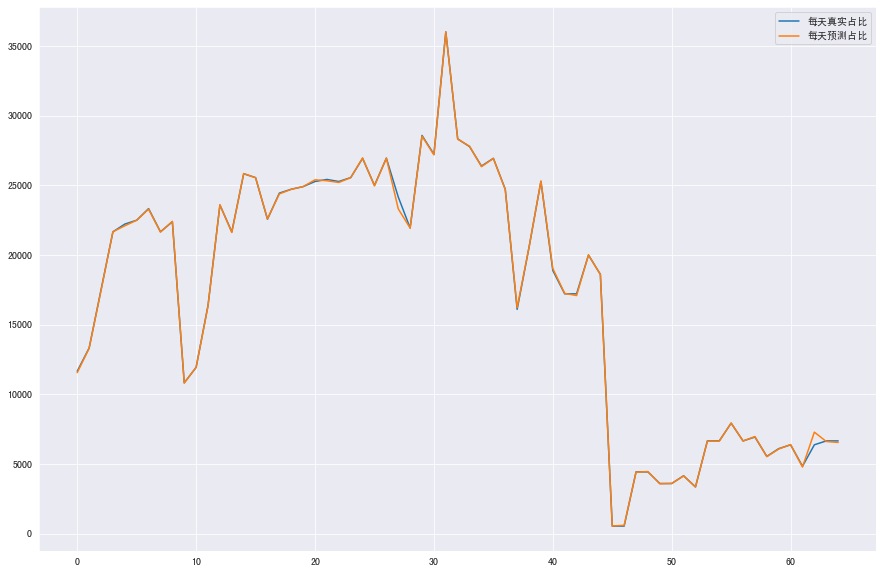

In [631]:
plt.figure(figsize=(15, 10))
plt.plot(labels_df.values, label='每天真实占比')
plt.plot(pred_all, label='每天预测占比')
plt.legend()

In [591]:
pred_all.shape

(65,)

In [667]:
# obj = HPOpt(features_hour_df.values, labels_hour_df.values)
# xgb_opt = obj.run(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=algo, max_evals=1000, early_stopping=100)
# params = xgb_opt[0]['reg_params']
# gamma对模型的结果影响很大！！！
# reg = xgb.XGBRegressor(**params)
reg = xgb.XGBRegressor(reg_alpha=0.03)
reg.fit(features_hour_df.values, labels_hour_df.values)
pred_all_hour = reg.predict(features_hour_df.values)

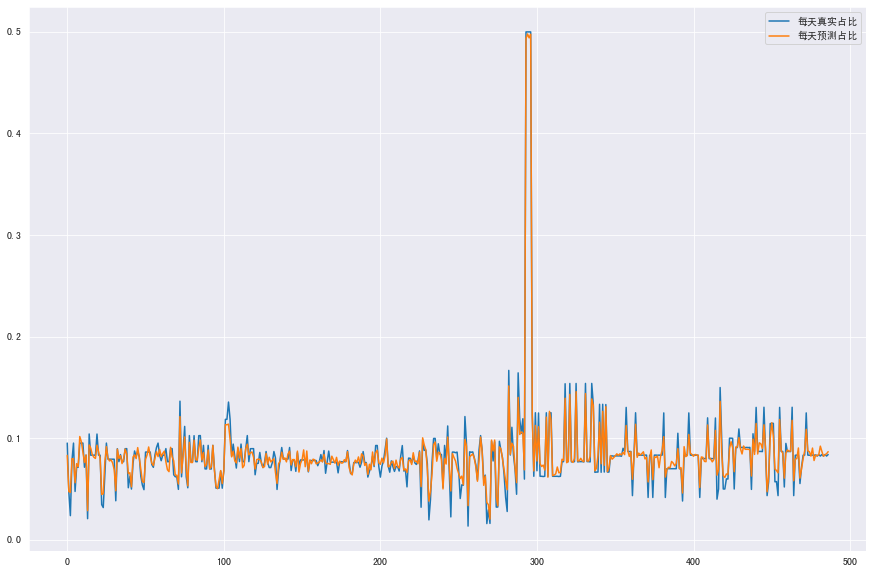

In [668]:
plt.figure(figsize=(15, 10))
plt.plot(labels_hour_df.values, label='每天真实占比')
plt.plot(pred_all_hour, label='每天预测占比')
plt.legend()

In [669]:
# 获取被预测的小时对应的原始数据
output_hour_df = merge_hour_df.loc[feature_hour_idx]
output_hour_df

,day,hour,cold_capacity,cold_ratio,date
5,2021-06-02,7,1111.200000,0.095233,2021-06-02 07:00:00
6,2021-06-02,8,555.600000,0.047617,2021-06-02 08:00:00
7,2021-06-02,9,277.800000,0.023808,2021-06-02 09:00:00
8,2021-06-02,10,909.163636,0.077918,2021-06-02 10:00:00
9,2021-06-02,11,1111.200000,0.095233,2021-06-02 11:00:00
...,...,...,...,...,...
1042,2022-08-05,13,560.000000,0.083971,2022-08-05 13:00:00
1043,2022-08-05,14,550.000000,0.082471,2022-08-05 14:00:00
1044,2022-08-05,15,560.000000,0.083971,2022-08-05 15:00:00
1045,2022-08-05,16,550.000000,0.082471,2022-08-05 16:00:00


In [670]:
output_hour_df['pre_cold_ratio'] = pred_all_hour
output_hour_df

,day,hour,cold_capacity,cold_ratio,date,pre_cold_ratio
5,2021-06-02,7,1111.200000,0.095233,2021-06-02 07:00:00,0.083143
6,2021-06-02,8,555.600000,0.047617,2021-06-02 08:00:00,0.047522
7,2021-06-02,9,277.800000,0.023808,2021-06-02 09:00:00,0.046759
8,2021-06-02,10,909.163636,0.077918,2021-06-02 10:00:00,0.079799
9,2021-06-02,11,1111.200000,0.095233,2021-06-02 11:00:00,0.079799
...,...,...,...,...,...,...
1042,2022-08-05,13,560.000000,0.083971,2022-08-05 13:00:00,0.086973
1043,2022-08-05,14,550.000000,0.082471,2022-08-05 14:00:00,0.082279
1044,2022-08-05,15,560.000000,0.083971,2022-08-05 15:00:00,0.083746
1045,2022-08-05,16,550.000000,0.082471,2022-08-05 16:00:00,0.084749


In [651]:
output_day_df = merge_day_df.loc[feature_idx]
output_day_df

,date,cold_capacity
0,2021-06-02,11668.200000
1,2021-06-04,13334.400000
2,2021-06-07,17501.800000
3,2021-06-09,21668.000000
4,2021-06-10,22224.000000
...,...,...
92,2022-08-01,6389.000000
93,2022-08-02,4849.454545
94,2022-08-03,6390.000000
95,2022-08-04,6667.000000


In [652]:
output_day_df['pre_cold_capacity'] = pred_all
output_day_df.rename(columns={'date': 'day', 'cold_capacity': 'cold_capacity_day'}, inplace=True)
output_day_df

,day,cold_capacity_day,pre_cold_capacity
0,2021-06-02,11668.200000,11565.296875
1,2021-06-04,13334.400000,13311.748047
2,2021-06-07,17501.800000,17461.166016
3,2021-06-09,21668.000000,21676.279297
4,2021-06-10,22224.000000,22099.933594
...,...,...,...
92,2022-08-01,6389.000000,6402.789551
93,2022-08-02,4849.454545,4793.900391
94,2022-08-03,6390.000000,7296.244629
95,2022-08-04,6667.000000,6626.035156


In [671]:
output_df = pd.merge(output_hour_df, output_day_df, on='day')
output_df

,day,hour,cold_capacity,cold_ratio,date,pre_cold_ratio,cold_capacity_day,pre_cold_capacity
0,2021-06-02,7,1111.200000,0.095233,2021-06-02 07:00:00,0.083143,11668.2,11565.296875
1,2021-06-02,8,555.600000,0.047617,2021-06-02 08:00:00,0.047522,11668.2,11565.296875
2,2021-06-02,9,277.800000,0.023808,2021-06-02 09:00:00,0.046759,11668.2,11565.296875
3,2021-06-02,10,909.163636,0.077918,2021-06-02 10:00:00,0.079799,11668.2,11565.296875
4,2021-06-02,11,1111.200000,0.095233,2021-06-02 11:00:00,0.079799,11668.2,11565.296875
...,...,...,...,...,...,...,...,...
469,2022-08-05,13,560.000000,0.083971,2022-08-05 13:00:00,0.086973,6669.0,6556.895996
470,2022-08-05,14,550.000000,0.082471,2022-08-05 14:00:00,0.082279,6669.0,6556.895996
471,2022-08-05,15,560.000000,0.083971,2022-08-05 15:00:00,0.083746,6669.0,6556.895996
472,2022-08-05,16,550.000000,0.082471,2022-08-05 16:00:00,0.084749,6669.0,6556.895996


In [672]:
# 取7-19点都有数的天
output_res = pd.DataFrame()
g = output_df.groupby('day')
for d, df in g:
    if df['hour'].values.shape[0] >= 8:
        output_res = pd.concat([output_res, df], ignore_index=True, sort=False)
output_res

,day,hour,cold_capacity,cold_ratio,date,pre_cold_ratio,cold_capacity_day,pre_cold_capacity
0,2021-06-02,7,1111.200000,0.095233,2021-06-02 07:00:00,0.083143,11668.2,11565.296875
1,2021-06-02,8,555.600000,0.047617,2021-06-02 08:00:00,0.047522,11668.2,11565.296875
2,2021-06-02,9,277.800000,0.023808,2021-06-02 09:00:00,0.046759,11668.2,11565.296875
3,2021-06-02,10,909.163636,0.077918,2021-06-02 10:00:00,0.079799,11668.2,11565.296875
4,2021-06-02,11,1111.200000,0.095233,2021-06-02 11:00:00,0.079799,11668.2,11565.296875
...,...,...,...,...,...,...,...,...
355,2022-08-05,13,560.000000,0.083971,2022-08-05 13:00:00,0.086973,6669.0,6556.895996
356,2022-08-05,14,550.000000,0.082471,2022-08-05 14:00:00,0.082279,6669.0,6556.895996
357,2022-08-05,15,560.000000,0.083971,2022-08-05 15:00:00,0.083746,6669.0,6556.895996
358,2022-08-05,16,550.000000,0.082471,2022-08-05 16:00:00,0.084749,6669.0,6556.895996


In [673]:
output_res['predict'] = output_res['pre_cold_capacity'] * output_res['pre_cold_ratio']

In [674]:
output_res

,day,hour,cold_capacity,cold_ratio,date,pre_cold_ratio,cold_capacity_day,pre_cold_capacity,predict
0,2021-06-02,7,1111.200000,0.095233,2021-06-02 07:00:00,0.083143,11668.2,11565.296875,961.578796
1,2021-06-02,8,555.600000,0.047617,2021-06-02 08:00:00,0.047522,11668.2,11565.296875,549.604736
2,2021-06-02,9,277.800000,0.023808,2021-06-02 09:00:00,0.046759,11668.2,11565.296875,540.784668
3,2021-06-02,10,909.163636,0.077918,2021-06-02 10:00:00,0.079799,11668.2,11565.296875,922.894775
4,2021-06-02,11,1111.200000,0.095233,2021-06-02 11:00:00,0.079799,11668.2,11565.296875,922.894775
...,...,...,...,...,...,...,...,...,...
355,2022-08-05,13,560.000000,0.083971,2022-08-05 13:00:00,0.086973,6669.0,6556.895996,570.276123
356,2022-08-05,14,550.000000,0.082471,2022-08-05 14:00:00,0.082279,6669.0,6556.895996,539.492310
357,2022-08-05,15,560.000000,0.083971,2022-08-05 15:00:00,0.083746,6669.0,6556.895996,549.113281
358,2022-08-05,16,550.000000,0.082471,2022-08-05 16:00:00,0.084749,6669.0,6556.895996,555.692932


In [676]:
# 写入mysql
# output_predict = output_res[['date', 'predict']]
# output_predict

,date,predict
0,2021-06-02 07:00:00,961.578796
1,2021-06-02 08:00:00,549.604736
2,2021-06-02 09:00:00,540.784668
3,2021-06-02 10:00:00,922.894775
4,2021-06-02 11:00:00,922.894775
...,...,...
355,2022-08-05 13:00:00,570.276123
356,2022-08-05 14:00:00,539.492310
357,2022-08-05 15:00:00,549.113281
358,2022-08-05 16:00:00,555.692932


In [680]:
# output_predict['current_date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# output_predict

C:\Users\zhangym\AppData\Local\Temp\ipykernel_15760\3662814866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_predict['current_date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')


,date,predict,current_date
0,2021-06-02 07:00:00,961.578796,2022-08-18 20:30:50
1,2021-06-02 08:00:00,549.604736,2022-08-18 20:30:50
2,2021-06-02 09:00:00,540.784668,2022-08-18 20:30:50
3,2021-06-02 10:00:00,922.894775,2022-08-18 20:30:50
4,2021-06-02 11:00:00,922.894775,2022-08-18 20:30:50
...,...,...,...
355,2022-08-05 13:00:00,570.276123,2022-08-18 20:30:50
356,2022-08-05 14:00:00,539.492310,2022-08-18 20:30:50
357,2022-08-05 15:00:00,549.113281,2022-08-18 20:30:50
358,2022-08-05 16:00:00,555.692932,2022-08-18 20:30:50


In [681]:
# output_predict['project_id'] = 0
# output_predict['interval'] = '1H'
# output_predict.rename(columns={'date': 'pre_date', 'predict': 'pre_ch'}, inplace=True)
# output_predict

C:\Users\zhangym\AppData\Local\Temp\ipykernel_15760\1124937144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_predict['project_id'] = 0
C:\Users\zhangym\AppData\Local\Temp\ipykernel_15760\1124937144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_predict['interval'] = '1H'
C:\Users\zhangym\AppData\Local\Temp\ipykernel_15760\1124937144.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

,pre_date,pre_ch,current_date,project_id,interval
0,2021-06-02 07:00:00,961.578796,2022-08-18 20:30:50,0,1H
1,2021-06-02 08:00:00,549.604736,2022-08-18 20:30:50,0,1H
2,2021-06-02 09:00:00,540.784668,2022-08-18 20:30:50,0,1H
3,2021-06-02 10:00:00,922.894775,2022-08-18 20:30:50,0,1H
4,2021-06-02 11:00:00,922.894775,2022-08-18 20:30:50,0,1H
...,...,...,...,...,...
355,2022-08-05 13:00:00,570.276123,2022-08-18 20:30:50,0,1H
356,2022-08-05 14:00:00,539.492310,2022-08-18 20:30:50,0,1H
357,2022-08-05 15:00:00,549.113281,2022-08-18 20:30:50,0,1H
358,2022-08-05 16:00:00,555.692932,2022-08-18 20:30:50,0,1H


In [683]:
# output_predict.to_csv('predict_cold_capacity_per_hour.csv', encoding='utf_8_sig', index=False)

# cop计算：热量/（电量+气量）（待优化）

In [145]:
# 获取电量数据
db = pymysql.connect(host='8.141.169.219',
                     user='root',
                     password='Zrhdb#2019',
                     port=3307,
                     database='WeiCloudAirDB.V4')
cursor = db.cursor()
sql = "SELECT * FROM `Tb_Ammeter_History` WHERE `parm_002` IN (469951239905824,469951284529696,469951294301216,469951306106400,469951321369120,469951383817248,469951394193440,478498583236640) AND `parm_003`<'2022-08-30' AND `parm_003`>='2021-01-01'"
cursor.execute(sql)
elec = cursor.fetchall()
db.close()

In [146]:
col = [f[0] for f in cursor.description]
elec_df = pd.DataFrame(list(elec), columns=col)

In [147]:
elec_df.shape

(911270, 39)

In [148]:
# 获取燃气表数据
db = pymysql.connect(host='8.141.169.219',
                     user='root',
                     password='Zrhdb#2019',
                     port=3307,
                     database='WeiCloudAirDB.V4')
cursor = db.cursor()
sql = "SELECT * FROM `Tb_GasMeter_History` WHERE `parm_002` IN(474822580231200,474822841727008) AND `parm_003` < '2022-08-30' AND `parm_003` >= '2021-01-01'"
cursor.execute(sql)
gas = cursor.fetchall()
db.close()

In [150]:
col = [f[0] for f in cursor.description]
gas_df = pd.DataFrame(list(gas), columns=col)
gas_df.shape

(75356, 7)

In [175]:
gas_df

,id,parm_001,parm_002,parm_003,Gm_Parm_001,Gm_Parm_002,Gm_Parm_003
0,470743885299232,2021-08-11 13:10:00,474822580231200,2021-08-11 16:24:26,54.0,308122.0,None
1,474822841727008,2021-08-11 08:10:00,474822841727008,2021-08-11 08:10:00,56.0,411474.0,None
2,474822841727009,2021-08-11 11:10:00,474822841727008,2021-08-11 16:22:50,51.0,411474.0,None
3,474822841727010,2021-08-11 13:10:00,474822841727008,2021-08-11 16:23:31,53.0,411400.0,None
4,474916477334560,2021-03-11 18:40:30,474822580231200,2021-03-11 18:40:45,0.0,NaN,None
...,...,...,...,...,...,...,...
75351,497874585396256,2022-08-12 18:12:03,474822841727008,2022-08-12 18:15:00,0.0,469420.0,None
75352,497874739259426,2022-08-12 18:16:04,474822841727008,2022-08-12 18:20:00,0.0,469420.0,None
75353,497874892559904,2022-08-12 18:20:04,474822841727008,2022-08-12 18:25:00,0.0,469420.0,None
75354,497875047246368,2022-08-12 18:20:04,474822841727008,2022-08-12 18:30:00,0.0,469420.0,None


In [ ]:
# 燃气表需要识别总量数据，数字识别算法需要优化